## Predicting age profile of Abalone

Predict the age profile of Abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it,and counting the number of rings through a microscope -- a boring and time-consuming task. Other measurements, which are easier to obtain, are used to predict the age.

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

## Exploratory analysis

Load the dataset and do some quick exploratory analysis.

In [2]:
column_names = ['Sex', 
                'Length', 
                'Diameter', 
                'Height', 
                'Whole_weight',
                'Shucked_weight', 
                'Viscera_weight', 
                'Shell_weight', 
                'Rings']

data = pd.read_csv('abalone.txt', index_col=False, delimiter = ",", names=column_names)
data.head(5)

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [3]:
print(data.shape)

(4177, 9)


In [4]:
data.describe()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


## Data visualisation and pre-processing


Let's take a look at the number of Male, Female and Infant samples from the dataset. From the output shown below, the distribution between the 3 categories is balance.

In [5]:
print(data.groupby('Sex').size())

Sex
F    1307
I    1342
M    1528
dtype: int64


Next, we visualise the data using density plots to get a sense of the data distribution. From the outputs below, you can see the data shows a general gaussian distribution. 

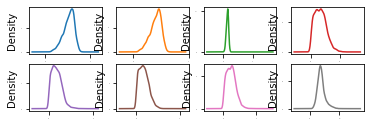

In [6]:
data.plot(kind='density', subplots=True, layout=(4,4), sharex=False, legend=False, fontsize=1)
plt.show()

It is good to check the correlations between the attributes. From the output graph below, The red around
the diagonal suggests that attributes are correlated with each other. The yellow and green patches suggest some moderate correlation and the blue boxes show negative correlations. 

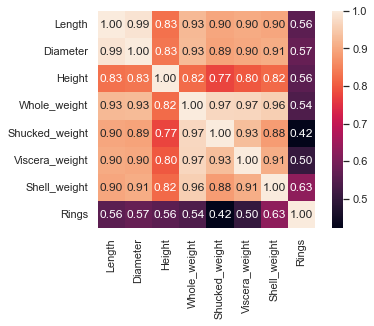

In [7]:
import seaborn as sns

correlation_map = data.corr(method='pearson')
sns.set(font_scale=1.0)
sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.2f', 
            yticklabels=correlation_map.columns.values, 
            xticklabels=correlation_map.columns.values)

plt.show()

In [8]:
sex = {'M': 1, 'F': 2, 'I': 0}
# Use the dictionary to map the 'winner' column to the new column: election['color']
data['Sex'] = data.Sex.map(sex)

In [9]:
from sklearn.model_selection import train_test_split

Y = data['Rings'].values
X = data.drop('Rings', axis=1).values

X_train, X_test, Y_train, Y_test = train_test_split (X, Y, test_size = 0.20, random_state=21)

## Baseline algorithm checking


In [10]:
import lazypredict
from lazypredict.Supervised import LazyRegressor

/Users/christopher_sia/opt/anaconda3/envs/python37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [11]:
reg = LazyRegressor(verbose=0,
                    ignore_warnings=True, 
                    custom_metric=None,
                    random_state=12)

models, predictions = reg.fit(X_train, X_test, Y_train, Y_test)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.20it/s]


In [14]:
models.head(15)

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
MLPRegressor,0.57,0.57,2.21,1.43
HistGradientBoostingRegressor,0.54,0.55,2.28,0.49
LGBMRegressor,0.54,0.55,2.28,0.07
ExtraTreesRegressor,0.54,0.55,2.29,0.54
RandomForestRegressor,0.54,0.54,2.29,1.01
GradientBoostingRegressor,0.54,0.54,2.29,0.34
LinearRegression,0.54,0.54,2.30,0.01
TransformedTargetRegressor,0.54,0.54,2.30,0.01
Lars,0.54,0.54,2.30,0.02


In [20]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold, GridSearchCV

model = MLPRegressor(early_stopping=True)
k = 5
param_grid = {
    'activation' : ['logistic', 'tanh', 'relu'], 
    'solver' : ['lbfgs', 'sgd', 'adam'],
    'learning_rate' : ['adaptive']
             }

skfold = KFold(n_splits=k, shuffle=True, random_state=21)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, scoring='neg_mean_squared_error', cv=skfold)
start = time.time()
grid_result = grid.fit(X_train, Y_train)
end = time.time()

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("NMSE: {:.4f} STD: {:.4f} with: {}".format(mean, stdev, param))

print("Best: {:.4f} using {} (run time : {:.3f})".format(grid_result.best_score_, grid_result.best_params_, end-start))


MSE: -4.2580 STD: 0.1587 with: {'activation': 'logistic', 'learning_rate': 'adaptive', 'solver': 'lbfgs'}
MSE: -6.8183 STD: 0.1553 with: {'activation': 'logistic', 'learning_rate': 'adaptive', 'solver': 'sgd'}
MSE: -6.5895 STD: 0.2512 with: {'activation': 'logistic', 'learning_rate': 'adaptive', 'solver': 'adam'}
MSE: -4.2681 STD: 0.2669 with: {'activation': 'tanh', 'learning_rate': 'adaptive', 'solver': 'lbfgs'}
MSE: -4.8410 STD: 0.2088 with: {'activation': 'tanh', 'learning_rate': 'adaptive', 'solver': 'sgd'}
MSE: -4.9906 STD: 0.1866 with: {'activation': 'tanh', 'learning_rate': 'adaptive', 'solver': 'adam'}
MSE: -4.2980 STD: 0.2821 with: {'activation': 'relu', 'learning_rate': 'adaptive', 'solver': 'lbfgs'}
MSE: -4.7347 STD: 0.1845 with: {'activation': 'relu', 'learning_rate': 'adaptive', 'solver': 'sgd'}
MSE: -4.7951 STD: 0.2692 with: {'activation': 'relu', 'learning_rate': 'adaptive', 'solver': 'adam'}
Best: -4.2580 using {'activation': 'logistic', 'learning_rate': 'adaptive', 'so

In [22]:
model = MLPRegressor(early_stopping=True)
model.set_params(**grid.best_params_)

print("Training model with best parameters={}".format(grid.best_params_))
start = time.time()
model.fit(X_train, Y_train)
end = time.time()

print("Training completed with run time {:.3f} seconds".format(end-start))

Training model with best parameters={'activation': 'logistic', 'learning_rate': 'adaptive', 'solver': 'lbfgs'}
Training completed with run time 0.990 seconds


In [24]:
from sklearn.metrics import mean_squared_error

print("Validate model on test set")
predict_test = model.predict(X_test)
print('RMSE on test data: {:.4f}'.format(mean_squared_error(Y_test, predict_test)**(0.5)))

Validate model on test set
RMSE on test data: 2.2010


In [26]:
diff = abs(Y_test - predict_test)
percent_diff = diff/Y_test * 100

compare = pd.DataFrame({'Ground Truths' : Y_test, 
                        'Prediction': predict_test.round(decimals=2), 
                        'Difference': diff.round(decimals=2),
                        '% Difference': percent_diff.round(decimals=2)})
compare.head(10)

,Ground Truths,Prediction,Difference,% Difference
0,12,10.65,1.35,11.24
1,12,10.22,1.78,14.85
2,8,9.14,1.14,14.19
3,9,8.92,0.08,0.86
4,10,7.66,2.34,23.37
5,9,10.63,1.63,18.08
6,10,10.71,0.71,7.06
7,10,11.68,1.68,16.84
8,10,9.33,0.67,6.71
9,8,8.75,0.75,9.34
